### 拳擊辨識系統 Boxing Identification System (BIS)

#### Import Resources

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

#### Data

In [3]:
DATASET_DIR = "../output"   # 資料夾結構
CLASSES = ["cross", "uppercut", "rear_hook", "jab"]
SEQUENCE_LENGTH = 64      # 每個動作序列包含 64 個 frames (可依影片fps調整)
KEYPOINT_DIM = 2          # MoveNet 2D keypoints: x, y
NUM_KEYPOINTS = 17        # MoveNet 預設17個關鍵點
NUM_CLASSES = len(CLASSES)

### ADD NOISE

In [4]:
def add_noise(sequence, noise_level=0.01):
    """
    Adds Gaussian noise to a single sequence (shape: 64, 17, 2).
    """
    # Create noise with the same shape as the sequence
    # This noise is centered at 0.0 with a standard deviation of noise_level
    noise = np.random.normal(0.0, noise_level, sequence.shape)
    
    # Add the noise to the original sequence
    augmented_sequence = sequence + noise
    
    # We should clip the values to stay within the 0.0-1.0 range
    # (assuming data is normalized or will be)
    augmented_sequence = np.clip(augmented_sequence, 0.0, 1.0)
    
    return augmented_sequence

#### 讀取 Move Net Features

In [5]:
def load_movenet_data():
    X = []
    Y = []

    for label_idx, label_name in enumerate(CLASSES):
        class_dir = os.path.join(DATASET_DIR, label_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found for class '{label_name}': {class_dir}")
            continue

        for file in os.listdir(class_dir):
            if file.endswith("_keypoints.npy"):
                path = os.path.join(class_dir, file)

                sequence = np.load(path)  # shape (51, 64)

                # Transpose from (Features, Time) to (Time, Features)
                sequence = sequence.T # (51, 64) -> (64, 51) 

                # Check if frame count matches constant
                if sequence.shape[0] != SEQUENCE_LENGTH:
                    print(f"Warning: File {file} has {sequence.shape[0]} frames, expected {SEQUENCE_LENGTH}. Skipping.")
                    continue
                
                # Reshape features from 51 to (17, 3)
                try:
                    sequence = sequence.reshape(SEQUENCE_LENGTH, NUM_KEYPOINTS, 3)
                except ValueError as e:
                    print(f"Error reshaping {file}. Shape was {sequence.shape}. Error: {e}")
                    continue
                
                # Select only y, x to match KEYPOINT_DIM, discards confidence 
                sequence = sequence[:, :, :2] # selects y, x coordinates

                #Append Prepared Data
                X.append(sequence)
                Y.append(label_idx)

                augmented_sequence = add_noise(sequence, noise_level=0.01)
                X.append(augmented_sequence)
                Y.append(label_idx)

    if len(X) == 0:
        print(f"Error: No data was loaded. Check DATASET_DIR ('{DATASET_DIR}') and CLASSES ({CLASSES}).")
        return np.array([]), np.array([])
    
    X = np.array(X)  # (N, 64, 17, 2)
    Y = np.array(Y)  # (N,)
    print(f"✅ Loaded data: {X.shape[0]} samples, shape per sample {X.shape[1:]}")

    return X, Y

#### Data Split and Normalization

In [6]:
def prepare_dataset(X, Y):
    # 正規化: 把 keypoint 座標壓在 [0,1]
    # X = X / np.max(X)

    # 分割訓練 / 驗證 / 測試
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42)

    # one-hot encoding
    Y_train = to_categorical(Y_train, NUM_CLASSES)
    Y_val = to_categorical(Y_val, NUM_CLASSES)
    Y_test = to_categorical(Y_test, NUM_CLASSES)

    print(f"🧩 Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

#### CNN - LSTM Model

In [ ]:
def build_cnn_lstm_model():
    model = models.Sequential([
        # Block 1
        layers.TimeDistributed(layers.Conv2D(32, (3, 2), activation='relu', padding='same'),
                               input_shape=(SEQUENCE_LENGTH, NUM_KEYPOINTS, KEYPOINT_DIM, 1)),\
        layers.TimeDistributed(layers.BatchNormalization()),
        layers.TimeDistributed(layers.MaxPooling2D((2, 1))),

        # Block 2
        layers.TimeDistributed(layers.Conv2D(64, (3, 2), activation='relu', padding='same')),
        layers.TimeDistributed(layers.BatchNormalization()),
        layers.TimeDistributed(layers.Flatten()),

        # LSTM
        layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
        layers.LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),

        # Classifier Head
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

### Plot

In [8]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Main Code

✅ Loaded data: 194 samples, shape per sample (64, 17, 2)
🧩 Train: (135, 64, 17, 2), Val: (29, 64, 17, 2), Test: (30, 64, 17, 2)


c:\Users\Ken\anaconda3\envs\ml_lab3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 64, 17, 2, 32)  │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 64, 17, 2, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 64, 8, 2, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 64, 8, 2, 64)   │        12,352 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 64, 8, 2, 64)   │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 64, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64, 128)        │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657,380 (2.51 MB)

 Trainable params: 657,060 (2.51 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.2751 - loss: 2.0459
Epoch 1: val_accuracy improved from None to 0.24138, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 761ms/step - accuracy: 0.3185 - loss: 1.7091 - val_accuracy: 0.2414 - val_loss: 1.4158
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.4511 - loss: 1.2806
Epoch 2: val_accuracy improved from 0.24138 to 0.34483, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.4741 - loss: 1.2134 - val_accuracy: 0.3448 - val_loss: 1.3598
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5220 - loss: 1.0574
Epoch 3: val_accuracy did not improve from 0.34483
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.5185 - loss: 1.0539 - val_accuracy: 0.3448 - val_loss: 1.2788
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6362 - loss: 0.8339
Epoch 4: val_accuracy improved from 0.34483 to 0.37931, saving model to best_model.keras

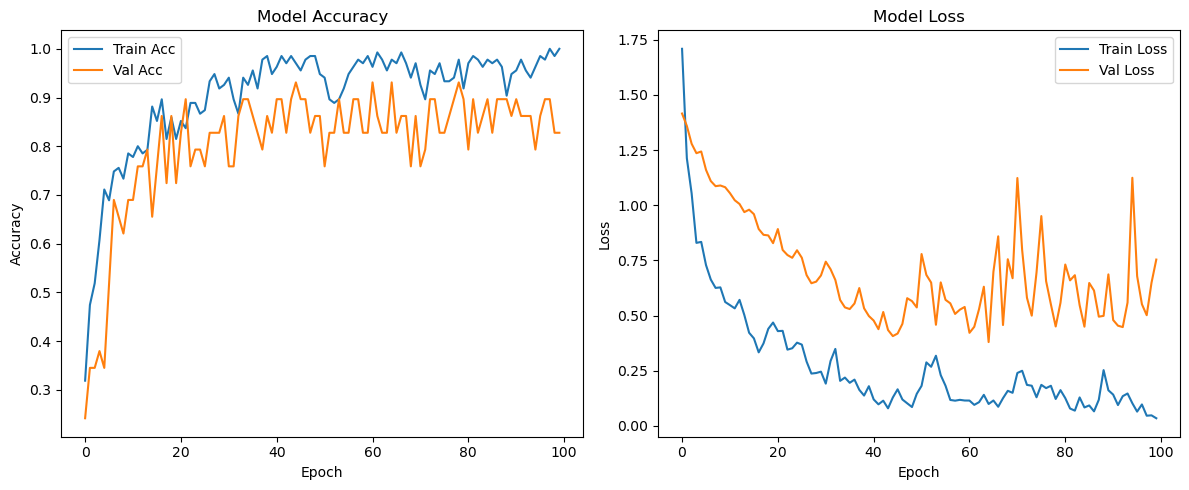

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9000 - loss: 0.5201
🎯 Test Accuracy: 0.9000


In [ ]:
if __name__ == "__main__":
    # 載入資料
    X, Y = load_movenet_data()
    if X.size == 0 or Y.size == 0:
        print("❌ No data loaded. Please check your dataset path and files.")
    else:
        # 整理 dataset
        X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_dataset(X, Y)

        # 增加 channel 維度 (for Conv2D)
        X_train = X_train[..., np.newaxis]
        X_val = X_val[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

        # 建立模型
        model = build_cnn_lstm_model()

        checkpoint = ModelCheckpoint(
            "best_model.keras",          
            monitor="val_accuracy",    
            save_best_only=True,
            mode="max",
            verbose=1
        )

        early_stop = EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True,
            verbose=1
        )

        # 訓練
        history = model.fit(
            X_train, Y_train,
            epochs=100,
            batch_size=16,
            validation_data=(X_val, Y_val),
            callbacks=[checkpoint, early_stop]
        )

        plot_history(history)

        # 測試
        test_loss, test_acc = model.evaluate(X_test, Y_test)
        print(f"🎯 Test Accuracy: {test_acc:.4f}")